# Проект 3 "О вкусной и здоровй пище"

# import

In [53]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from collections import Counter
# для кодирования городов
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [54]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [55]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [56]:
df_train.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
1369,id_1697,Amsterdam,['Pub'],1702.0,4.0,$,30.0,"[['Incredible', 'Best place for a pint'], ['12...",/Restaurant_Review-g188590-d6857652-Reviews-Zi...,d6857652
21612,id_14681,London,"['Japanese', 'Fast Food', 'Sushi', 'Asian']",14692.0,3.5,$,12.0,"[['Blond ninja', 'Popular place'], ['08/05/201...",/Restaurant_Review-g186338-d8765974-Reviews-Wa...,d8765974
18060,id_4859,Rome,['Pizza'],4860.0,4.5,$,36.0,"[['Pizza romana by the kilo', 'Fantastic Pizza...",/Restaurant_Review-g187791-d2244171-Reviews-Pi...,d2244171
39934,id_11032,London,NaN,11042.0,4.5,NaN,2.0,"[['Nice Fry-Up', 'Pretty much the best budget ...",/Restaurant_Review-g186338-d12458176-Reviews-C...,d12458176
31389,id_212,Prague,"['European', 'Czech', 'Eastern European', 'Cen...",213.0,4.5,$$$$,297.0,"[['Nice location', 'Great experience'], ['06/2...",/Restaurant_Review-g274707-d6714338-Reviews-Va...,d6714338


In [57]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [58]:
df_test.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
7231,id_7231,Madrid,"['Mediterranean', 'European', 'Spanish', 'Inte...",1223.0,$$ - $$$,260.0,"[['Nice Lunch', 'Mmm..'], ['11/21/2017', '07/2...",/Restaurant_Review-g187514-d1141467-Reviews-La...,d1141467
7310,id_7310,Madrid,NaN,6259.0,NaN,16.0,"[[], []]",/Restaurant_Review-g187514-d5489737-Reviews-Re...,d5489737
1877,id_1877,Warsaw,NaN,943.0,NaN,6.0,"[['quick tasty eat for a reasonable price', 'C...",/Restaurant_Review-g274856-d12069548-Reviews-T...,d12069548
2883,id_2883,Geneva,"['French', 'European']",1030.0,$$ - $$$,30.0,"[['Lovely Laid Back Setting', 'Rude staff'], [...",/Restaurant_Review-g188057-d1020323-Reviews-Le...,d1020323
6190,id_6190,Berlin,NaN,5167.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187323-d5818231-Reviews-Ci...,d5818231


In [59]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* Restaurant_id : идентификатор ресторана
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [61]:
df.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
45941,id_3265,Prague,"['European', 'Czech']",3272.0,NaN,2.0,"[[], []]",/Restaurant_Review-g274707-d7123596-Reviews-Re...,d7123596,1,4.0
13496,id_8850,Paris,"['Moroccan', 'Mediterranean']",8852.0,NaN,7.0,"[['Favourite Japanese Patisserie', 'Nice place...",/Restaurant_Review-g187147-d9830909-Reviews-Sa...,d9830909,1,4.0
35102,id_3620,Lisbon,NaN,3625.0,NaN,4.0,"[[], []]",/Restaurant_Review-g189158-d5959124-Reviews-Re...,d5959124,1,3.0
27731,id_5128,Paris,['Chinese'],5129.0,$$ - $$$,55.0,"[['childhood memories', 'L’Empire Céleste'], [...",/Restaurant_Review-g187147-d2428753-Reviews-L_...,d2428753,1,4.0
31952,id_8382,Paris,"['French', 'European', 'Vegetarian Friendly']",8383.0,$$ - $$$,131.0,[['Very good galettes & crepes and good value....,/Restaurant_Review-g187147-d1998007-Reviews-Le...,d1998007,1,4.0


# Очистка и обработка данных

In [62]:
#Убираю пробелы из названия переменных для дальнейшего удобства
df.columns = map(lambda name: name.strip().replace(" ", "_"), df.columns)
df.columns

Index(['Restaurant_id', 'City', 'Cuisine_Style', 'Ranking', 'Price_Range',
       'Number_of_Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating'],
      dtype='object')

### Обработка признаков

### 1. Restaurant_id

In [63]:
# Значения Restaurant_id превращаю в числовые:
if (df['Restaurant_id'].dtype != 'int64'): #условие что бы не вываливалась ошибка при перезапуске ячейки
    df['Restaurant_id'] = df['Restaurant_id'].apply(lambda x: int(x[3:]))
df.Restaurant_id.dtype

dtype('int64')

### 2. City

In [64]:
#Сколько городов представлено в наборе данных?
city_names = df.City.unique()

dict_names = {}
for num in range(len(city_names)):
    dict_names[city_names[num]] = num
#создаю колонки с данными о городах в которых расположены рестораны
#сначала меняю имена городов на цифр
def change_city(city):
    global dict_names
    return int(dict_names[city])
    
# эксперементально выяснил, что модель с думми переменными на несколько десятых точнее, чем модель с признаком с номерами городов
#df['City_num'] = df['City'].apply(lambda x: change_city(x))

#теперь разношу города по колонкам - ввожу думми переменные для городов:
df_dummies = pd.get_dummies(df.City).astype('int')

#объединяю исходный датафрейм с думми признаками
df = pd.merge(df,df_dummies, right_index=True, left_index=True)


In [65]:
#создаю признак по столицам
list_Of_Capital = [  'Paris', 'Helsinki', 'London', 'Bratislava', 'Lisbon', 'Budapest',
                     'Stockholm', 'Rome', 'Prague', 'Vienna', 'Dublin','Brussels', 'Madrid', 
                     'Oslo' ,'Amsterdam', 'Berlin', 'Athens', 'Warsaw', 'Copenhagen', 
                     'Luxembourg', 'Ljubljana']
df['Capital_City'] = df['City'].apply(lambda x: 1 if x in list_Of_Capital else 0)

In [66]:
#признак по населению городов
#todo постараться найти данные за 2018 год
сity_population = {'London' : 8908, 'Paris' : 2206, 'Madrid' : 3223, 'Barcelona' : 1620, 
                        'Berlin' : 6010, 'Milan' : 1366, 'Rome' : 2872, 'Prague' : 1308, 
                        'Lisbon' : 506, 'Vienna' : 1888, 'Amsterdam' : 860, 'Brussels' : 179, 
                        'Hamburg' : 1841, 'Munich' : 1457, 'Lyon' : 506, 'Stockholm' : 961, 
                        'Budapest' : 1752, 'Warsaw' : 1764, 'Dublin' : 553, 
                        'Copenhagen' : 616, 'Athens' : 665, 'Edinburgh' : 513, 
                        'Zurich' : 415, 'Oporto' : 240, 'Geneva' : 201, 'Krakow' : 769, 
                        'Oslo' : 681, 'Helsinki' : 643, 'Bratislava' : 426, 
                        'Luxembourg' : 119, 'Ljubljana' : 284}
df['city_population'] = df['City'].apply(lambda x: сity_population[x])

In [67]:
print(city_names)
print(len(city_names))

['Paris' 'Helsinki' 'Edinburgh' 'London' 'Bratislava' 'Lisbon' 'Budapest'
 'Stockholm' 'Rome' 'Milan' 'Munich' 'Hamburg' 'Prague' 'Vienna' 'Dublin'
 'Barcelona' 'Brussels' 'Madrid' 'Oslo' 'Amsterdam' 'Berlin' 'Lyon'
 'Athens' 'Warsaw' 'Oporto' 'Krakow' 'Copenhagen' 'Luxembourg' 'Zurich'
 'Geneva' 'Ljubljana']
31


### 3. Cuisine_Style

In [68]:
df['Cuisine_Style'].isna().sum()

11590

In [69]:
# в переменной 11590 пропущенных значений 

df['Cuisine_Style_NaN'] = pd.isna(df['Cuisine_Style']) 

# заполним пропуски значением 'nodata'
df['Cuisine_Style'] = df['Cuisine_Style'].fillna("['nodata']")

# кодирую значения в переменной
le = LabelEncoder()
le.fit(df['Cuisine_Style'])
df['code_Cuisine_Style'] = le.transform(df['Cuisine_Style'])

In [70]:
# проведем обработку значений переменной
df['Cuisine_Style'] = df['Cuisine_Style'].str.findall(r"'(\b.*?\b)'") 

temp_list = df['Cuisine_Style'].tolist()

def list_unrar(lst):
    result=[]
    for elem in lst:
      result.extend(elem)
    return result

temp_counter = Counter(list_unrar(temp_list))

In [71]:
# сформируем список достаточно уникальных кухонь и сформируем на его основе новый признак
list_of_unique_Cuisine = [x[0] for x in temp_counter.most_common()[-16:]]
df['unique_Cuisine_Style'] = df['Cuisine_Style'].apply(lambda x: 1 if len(set(x) & set(list_of_unique_Cuisine))>0  else 0).astype('float64')

In [72]:
for cuisine in temp_counter:
    df[cuisine] = df['Cuisine_Style'].apply(lambda x: 1 if cuisine in x else 0 ).astype('float64')

# генерируем новый признак кол-во кухонь в ресторане
df['count_Cuisine_Style'] = df['Cuisine_Style'].apply(lambda x: len(x)).astype('float64')

### 4. Ranking

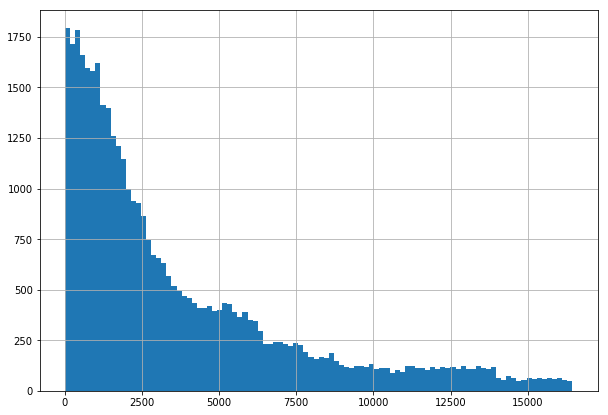

In [73]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

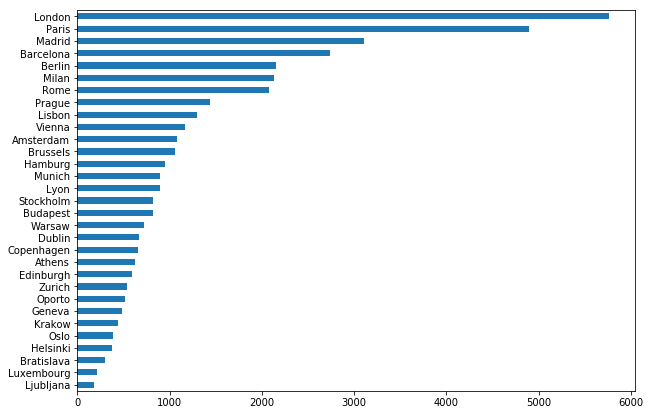

In [74]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

Посмотрим, как изменится распределение в большом городе:

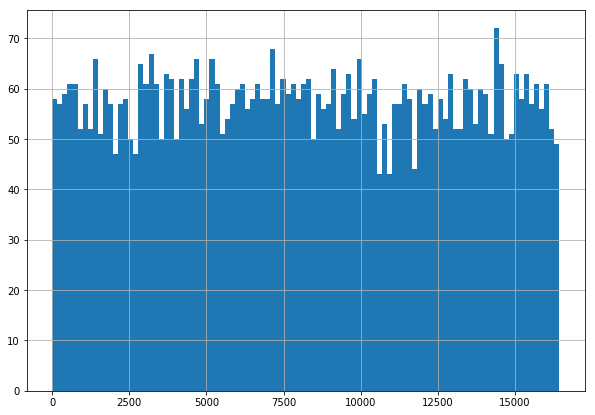

In [75]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

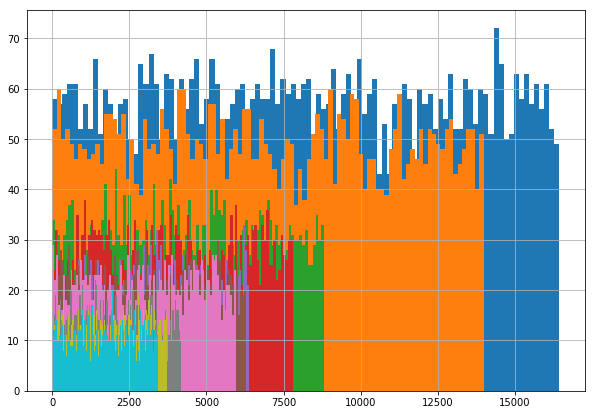

In [76]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

In [77]:
# нормирую Ranking по городам City
Ranking_City_mean = df.groupby(['City'])['Ranking'].mean()
Restorant_City_number = df['City'].value_counts(ascending=False)
df['Ranking_City_mean'] = df['City'].apply(lambda x: Ranking_City_mean[x])
df['Restorant_City_number'] = df['City'].apply(lambda x: Restorant_City_number[x])
df['Ranking_City_norm'] = (df['Ranking'] - df['Ranking_City_mean']) / df['Restorant_City_number']

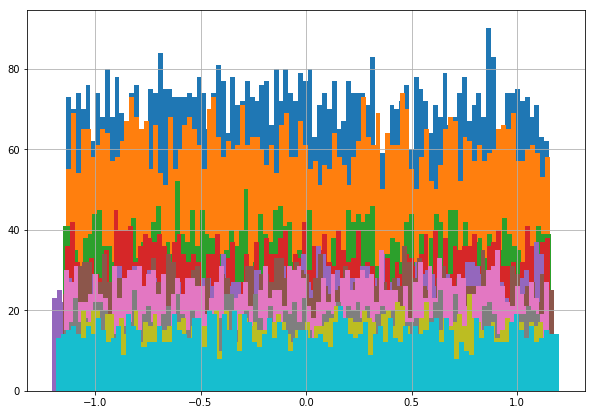

In [78]:
#после нормирования
for x in (df['City'].value_counts())[0:10].index:
    df['Ranking_City_norm'][df['City'] == x].hist(bins=100)
plt.show()

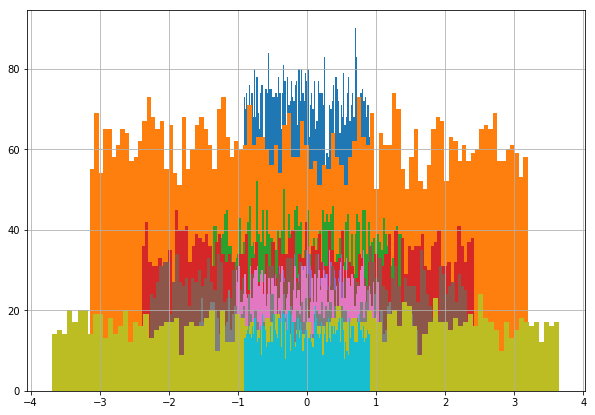

In [79]:
# критерий Ranking по населению в городах Population_Сity
df['Ranking_CityPopulation_norm'] = (df['Ranking'] - df['Ranking_City_mean']) / df['city_population']

for x in (df['City'].value_counts())[0:10].index:
    df['Ranking_CityPopulation_norm'][df['City'] == x].hist(bins=100)
plt.show()

In [80]:
df['norm_Population_on_Rest'] = df['city_population']/df['Restorant_City_number']

### 5. Price_Range

In [81]:
df['Price_Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price_Range, dtype: int64

In [82]:
#функция возвращает 1 для низких цен, 2 для средних цен и 3 для высоких цен. Для пустых значений 0.
def change_PR_symbol(sym):
    if sym == '$':
        return 1
    elif sym == '$$ - $$$':
        return 2
    elif sym == '$$$$':
        return 3
    #экспеременатльно выяснил, что лучше пропуски заполнять нулями
    return 0

# сохраняю переменную с пропусками
df['Price_Range_NaN'] = pd.isna(df['Price_Range'])
# конвертирую строковые значения в числовые.
df['Price_Range'] = df['Price_Range'].apply(lambda x: change_PR_symbol(x))

### 6. Reviews

In [83]:
#заполняю пропуски
df['Reviews'] = df['Reviews'].fillna('[[], []]')
#сохраняю пустые значения
df['Reviews_empty'] = df['Reviews'].apply(lambda x: 0 if (x == '[[], []]') else 1)


### 7. Number_of_Reviews

In [84]:
#сохраняю пропуски в переменной Number_of_Reviews
df['Number_of_Reviews_NAN'] = df['Number_of_Reviews'].isna()

#нахожу среднее значение
mean_number_of_rev = round(df.Number_of_Reviews.mean())

#если у ресторана нет отзывов в колонке Reviews и Number_of_Reviews = NaN, то заоплняю нулем
df['Number_of_Reviews'] = df[df.Reviews_empty == 0].Number_of_Reviews.fillna(0)
#в остальных случаях заполняю средним значением
df['Number_of_Reviews'] = df['Number_of_Reviews'].fillna(mean_number_of_rev)


> ### 8. ID_TA

In [85]:
#пытаюсь получить переменную из айди
df['ID_TA_code'] = df['ID_TA'].apply(lambda x: float(x[1:]))

> ### 9. URL_TA

In [86]:
#пытаюсь вычленить переменную из URL
df['URL_TA_code'] = df['URL_TA'].str.split('-').apply(lambda x: x[1][1:]).astype('float64')

Удаление не числовых столбцов

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 184 entries, Restaurant_id to URL_TA_code
dtypes: bool(3), float64(137), int64(39), object(5)
memory usage: 69.2+ MB


In [88]:
list_temp = list(feat_importances.nlargest(15).index[[0,1,6,10]])
df_temp[list_temp].corr()

NameError: name 'df_temp' is not defined

In [36]:
df.drop(['City', 'Cuisine_Style', 'Price_Range', 'Reviews', 'URL_TA', 'ID_TA','Ranking_City_mean', 'city_population', 'Restaurant_id'], axis=1, inplace=True, errors='ignore')

In [37]:
# функция для стандартизации
def StandardScaler_column(d_col):
    scaler = StandardScaler()
    scaler.fit(df[[d_col]])
    return scaler.transform(df[[d_col]])
# стандартизируем все столбцы кроме целевой и Sample
for i  in list(df.columns):
    if i not in ['Rating','sample']:
        df[i] = StandardScaler_column(i)
        if len(df[df[i].isna()]) < len(df):
            df[i] = df[i].fillna(0)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 175 entries, Ranking to URL_TA_code
dtypes: float64(174), int64(1)
memory usage: 66.8 MB


Разбиваем датасет на тренировочный и тестовый

In [39]:
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [40]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [41]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 174), (40000, 174), (40000, 173), (32000, 173), (8000, 173))

# Model 
Сам ML

In [42]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [43]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [44]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [45]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.25729250000000004


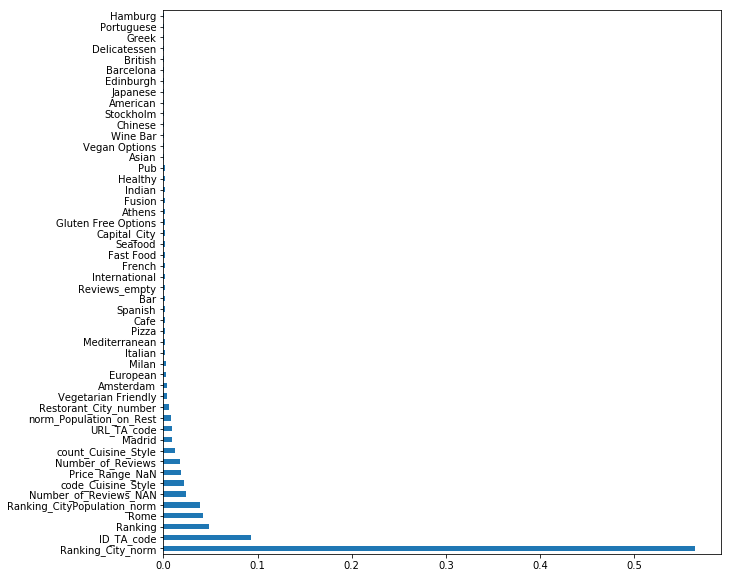

In [46]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(50).plot(kind='barh')

(15.5, -0.5)

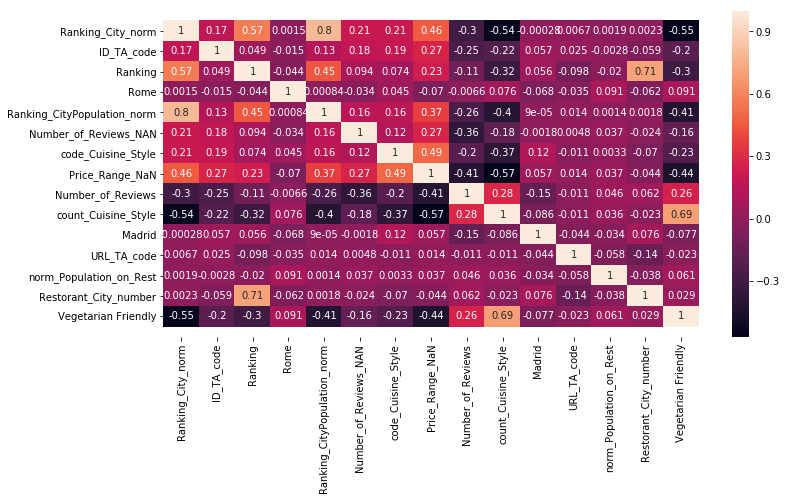

In [90]:
df_temp = df.loc[df['sample'] == 1, list(feat_importances.nlargest(15).index[0:15])]
plt.rcParams['figure.figsize'] = (12,6)
ax = sns.heatmap(df_temp.corr(), annot=True, fmt='.2g')
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

# Submission
Если все устраевает - готовим Submission на кагл

In [47]:
test_data.sample(10)

,Ranking,Number_of_Reviews,Rating,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,...,count_Cuisine_Style,Restorant_City_number,Ranking_City_norm,Ranking_CityPopulation_norm,norm_Population_on_Rest,Price_Range_NaN,Reviews_empty,Number_of_Reviews_NAN,ID_TA_code,URL_TA_code
6728,2.275526,0.430968,0.0,-0.167971,-0.125557,-0.2699,-0.239153,-0.087511,-0.164284,-0.14438,...,-0.891069,1.253945,1.262058,1.718022,-1.042799,-0.729321,0.440132,-0.261488,0.149819,-0.152399
9503,-0.617674,0.430968,0.0,-0.167971,-0.125557,-0.2699,-0.239153,-0.087511,-0.164284,-0.14438,...,-0.891069,-0.891837,0.099918,0.109317,-0.874284,-0.729321,0.440132,-0.261488,-0.702501,-0.151556
7898,-0.418217,-2.401738,0.0,-0.167971,-0.125557,-0.2699,-0.239153,-0.087511,-0.164284,-0.14438,...,-0.891069,-0.931892,1.275557,0.674113,0.044434,1.371138,-2.272045,-0.261488,0.214286,-0.133084
6543,1.275000,0.430968,0.0,-0.167971,-0.125557,-0.2699,-0.239153,-0.087511,-0.164284,-0.14438,...,0.205415,1.721263,0.044216,0.017554,0.633056,-0.729321,0.440132,-0.261488,-0.216270,-0.158175
7125,0.546363,0.430968,0.0,-0.167971,-0.125557,-0.2699,-0.239153,-0.087511,-0.164284,-0.14438,...,0.753658,0.265473,0.509789,0.296519,-0.118008,-0.729321,0.440132,-0.261488,-1.356223,-0.149778
8232,0.808251,-2.192768,0.0,-0.167971,-0.125557,-0.2699,-0.239153,-0.087511,-0.164284,-0.14438,...,-0.891069,0.265473,0.890515,0.517969,-0.118008,1.371138,-2.272045,-0.261488,-1.345535,-0.149778
3444,1.174732,0.430968,0.0,-0.167971,-0.125557,-0.2699,-0.239153,-0.087511,-0.164284,-0.14438,...,-0.891069,0.265473,1.423296,0.827861,-0.118008,1.371138,0.440132,-0.261488,1.525284,-0.149778
6630,1.173921,-2.215987,0.0,-0.167971,-0.125557,-0.2699,-0.239153,-0.087511,-0.164284,-0.14438,...,-0.891069,0.265473,1.422117,0.827176,-0.118008,1.371138,-2.272045,-0.261488,-0.171688,-0.149778
4543,-0.911724,0.430968,0.0,-0.167971,-0.125557,-0.2699,-0.239153,-0.087511,-0.164284,-0.14438,...,0.205415,-0.978409,-1.237705,-0.319092,1.910302,-0.729321,0.440132,-0.261488,0.378754,0.473859
5015,-0.477135,0.430968,0.0,-0.167971,-0.125557,-0.2699,-0.239153,-0.087511,-0.164284,-0.14438,...,0.753658,1.253945,-1.236086,-1.682668,-1.042799,-0.729321,0.440132,-0.261488,-0.118406,-0.152399


In [48]:
test_data = test_data.drop(['Rating'], axis=1)

In [49]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [50]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [51]:
predict_submission

array([3.01 , 4.23 , 4.625, ..., 3.04 , 4.48 , 4.51 ])

In [52]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.010
1,id_1,4.230
2,id_2,4.625
3,id_3,4.120
4,id_4,4.365
5,id_5,4.100
6,id_6,1.590
7,id_7,2.525
8,id_8,4.015
9,id_9,4.555
